In [1]:
import os
import json
import numpy as np
from shutil import copyfile
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import random 
import time
import math
import datetime


DATA_DIR = os.path.join("..", "data", "gigawordunsplit")
TRAIN_DIR = os.path.join("..", "data", "gigaword","train")
DEV_DIR = os.path.join("..", "data", "gigaword","dev")

for d in [DATA_DIR, TRAIN_DIR, DEV_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)

UNKNOWN_TOKEN = 'unk' 
MIN_FREQUENCY = 2
MIN_KNOWN_COUNT = 3
PAD_token = 0
SOS_token = 1
EOS_token = 2
#-------------------------
MIN_LENGTH = 3
MAX_LENGTH = 100
#-------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

Split data into 80% training and 20% dev.

In [ ]:
fnames = np.asarray(os.listdir(DATA_DIR))
train_end = int(len(fnames)*0.8)
np.random.shuffle(fnames)
i = 0
for fname in fnames:
    src = os.path.join(DATA_DIR, fname)
    if i < train_end:
        dst = os.path.join(TRAIN_DIR, fname)
    else:
        dst = os.path.join(DEV_DIR, fname)
    copyfile(src, dst)
    i = i + 1
        

Count the frequency of each word appears in the dataset

In [2]:
def update_freq_dict(freq_dict, tokens):
    for t in tokens:
        if t not in freq_dict:
            freq_dict[t] = 0
        freq_dict[t] += 1

def build_freq_dict(data_dir):
    freq_dict = dict()
    for fname in os.listdir(data_dir):
        fpath = os.path.join(data_dir, fname)
        with open(fpath) as f:
            for line in f:
                obj = json.loads(line)
                headline = [t for t in obj['Headline'].split()]
                text = [t for t in obj['Text'].split()]
                update_freq_dict(freq_dict, headline)
                update_freq_dict(freq_dict, text)
    return freq_dict

            
freq_dict = build_freq_dict(TRAIN_DIR)
print("Train data:")
print("Number of unique words before removing low frequency words:", len(freq_dict))


Train data:
Number of unique words before removing low frequency words: 312609


Convert words with frequency less than or equal to 2 to unk.  Ignore the article if it's headline has known word less than 3.

In [3]:
word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "unk": 3}
index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3:"unk"}
def remove_low_freq_words(freq_dict, tokens):
    filtered_tokens = []
    known_count = 0
    for t in tokens:
        if freq_dict[t] > MIN_FREQUENCY:
            filtered_tokens.append(t)
            known_count = known_count + 1
        else:
            filtered_tokens.append(UNKNOWN_TOKEN)
    return filtered_tokens, known_count
def update_word_index(word2index, index2word, tokens):
    for t in tokens:
        if t not in word2index:
            next_index = len(word2index)
            word2index[t] = next_index
            index2word[next_index] = t
def read_data(data_dir):
    ignore_count = 0
    data = []
    for fname in os.listdir(data_dir):
        fpath = os.path.join(data_dir, fname)
        with open(fpath) as f:
            for line in f:
                obj = json.loads(line)
                headline = [t for t in obj['Headline'].split()]
                text = [t for t in obj['Text'].split()]
                if data_dir == TRAIN_DIR:
                    headline, known_count = remove_low_freq_words(freq_dict, headline)
                    if known_count < MIN_KNOWN_COUNT:
                        ignore_count = ignore_count + 1
                        continue
                    #-------------------------------------------
                    #ignore if too short or too long?
                    text, _ = remove_low_freq_words(freq_dict, text) 
                    #--------------------------------------------
                    update_word_index(word2index, index2word, headline)
                    update_word_index(word2index, index2word, text)
                data.append({'Headline': headline, 'Text': text})
    return data, ignore_count
    
train_data, ignore_count = read_data(TRAIN_DIR)
print("Train data:")
print("Number of articles removed due to too less known words in headline:", ignore_count)
print("Number of unique words after removing low frequency words:", len(word2index))
dev_data, _ = read_data(DEV_DIR)

Train data:
Number of articles removed due to too less known words in headline: 334
Number of unique words after removing low frequency words: 110454


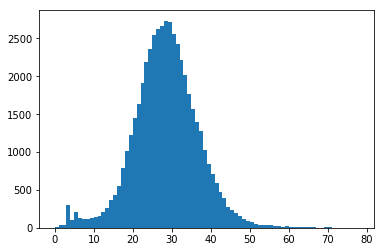

In [22]:
total= 0
L = []
indexes = np.random.choice(len(train_data), 50000)
for i in indexes:
    if(len(train_data[i]['Text']) < 80):
        L.append(len(train_data[i]['Text']))
import matplotlib.pyplot as plt
bw = 1
plt.hist(L, bins=range(min(L), max(L) +bw, bw))
plt.show()


## GloVe word embeddings
- We wrap this into a separate class for reusablility. Upon initialization, we will load the corresponding file containing all the pre-trained word embeddings (of a certain dimensionality), and we store them in a dictionary where keys are the words.
- The get_word_vector function takes in a word and try to look for an existing embedding in the GloVe model. If it fails to find the word, it will initialize a random vector of the same dimension for that word, and put it into the dictionary. This way if we happen to query this word again, we will at least return a consistent vector (as opposed to returning an "unkown" or zero vector for all unseen words).

In [ ]:
class GloVe():
    def __init__(self, path, dim):
        self.dim = dim
        self.word_embedding_dict = {}
        with open(path) as f:
            for line in f:
                values = line.split()
                embedding = values[-dim:]
                word = ''.join(values[:-dim])
                self.word_embedding_dict[word] = np.asarray(embedding, dtype=np.float32)
    
    def get_word_vector(self, word):
        if word not in self.word_embedding_dict.keys():
            embedding = np.random.uniform(low=-1, high=1, size=self.dim).astype(np.float32)
            self.word_embedding_dict[word] = embedding
            return embedding
        else:
            return self.word_embedding_dict[word]
glvmodel = GloVe(os.path.join('..', 'models', 'glove', 'glove.6B.200d.txt'), dim=200)

## Gather word embeddings for tokens in the training data
- Since the RNN needs machine-readable inputs (hence numbers instead of strings), we need to convert all labels to indices, and all words to embeddings with mappings to indices.
- For each token, we query the GloVe model for an embedding.

In [ ]:
pretrained_embeddings = []
assert len(word2index) == len(index2word)
for i in range(len(index2word)):
    pretrained_embeddings.append(glvmodel.get_word_vector(index2word[i]))


In [ ]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(tokens):
    default_idx = word2index[UNKNOWN_TOKEN]
    idxs = [word2index.get(word, default_idx) for word in tokens]
    return [SOS_token] + idxs + [EOS_token]

# Pad a sentence with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq


def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):

    length = Variable(torch.LongTensor(length)).to(device)
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.

    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


# copy from model.py

In [ ]:
class EncoderRNN(nn.Module):
    
    """ 
    Scalars: 
    input_size: vocabulary size
    hidden_size: the hidden dimension
    n_layers: number of hidden layers in GRU
    
    """ 
    def __init__(self, input_size, hidden_size, pretrained_embeddings, n_layers=1, dropout=0.1):
        
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        glove_embeddings = torch.tensor(pretrained_embeddings)
        self.embedding = nn.Embedding(input_size, hidden_size).\
                from_pretrained(glove_embeddings, freeze=False)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        embedded = self.embedding(input_seqs)
        
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        
        # unpack (back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) 
        
        # Sum bidirectional outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] 
        
        return outputs, hidden



class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        attn_energies = attn_energies.to(device)

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy


class DecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, pretrained_embeddings, n_layers=1, dropout=0.1):
        super(DecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers

        glove_embeddings = torch.tensor(pretrained_embeddings)
        self.embedding = nn.Embedding(output_size, hidden_size).\
                from_pretrained(glove_embeddings, freeze=False)

        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights


## copy from eval.py

In [ ]:
def evaluate(input_seq, encoder, decoder, max_length=MAX_LENGTH):
    with torch.no_grad(): 
        input_seqs = [indexes_from_sentence( input_seq)]
        input_lengths = [len(input_seq) for input_seq in input_seqs]
        input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1).to(device)
            
        # Set to not-training mode to disable dropout
        encoder.train(False)
        decoder.train(False)
        
        # Run through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

        # Create starting vectors for decoder
        decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
        
        decoder_input = decoder_input.to(device)

        # Store output words and attention states
        decoded_words = []
        decoder_attentions = torch.zeros(max_length + 1, max_length + 1).to(device)
        
        # Run through decoder
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).data
            #decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).to(config.device).data

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            if ni == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(index2word[int(ni)])
                
            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([ni]))
            decoder_input = decoder_input.to(device)

        # Set back to training mode
        encoder.train(True)
        decoder.train(True)
        
        return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

def evaluate_randomly(encoder, decoder, pairs):
    article = random.choice(pairs)
    headline = article['Headline']
    text = article['Text']
    print('>', text)
    if headline is not None:
        print('=', headline)

    output_words, attentions = evaluate(headline, encoder, decoder)
    output_words = output_words
    output_sentence = ' '.join(output_words)
    
    print('<', output_sentence)
    

def eval_random_batch(batch_size):
    
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence( pair['Text']))
        target_seqs.append(indexes_from_sentence(pair['Headline']))

    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    input_var = input_var.to(device)
    target_var = target_var.to(device)
        
    return input_var, input_lengths, target_var, target_lengths


## copy from train.py

In [ ]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

def save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer,  name="eng_fra_model.pt"):
    path = "../models/" + name
    torch.save({
                'encoder_model_state_dict': encoder.state_dict(),
                'decoder_model_state_dict': decoder.state_dict(),
                'timestamp': str(datetime.datetime.now()),
                }, path)

                #'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                #'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),


def train(input_batches, input_lengths, target_batches, target_lengths, batch_size, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, clip):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    input_batches = input_batches.to(device)

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder


    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)


    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    #return loss.data[0], ec, dc
    return loss.item(), ec, dc

def restore_training(encoder, decoder):
    print("Restoring training environment")
    checkpt = torch.load('../models/sum_model.pt')
    encoder.load_state_dict(checkpt["encoder_model_state_dict"])
    decoder.load_state_dict(checkpt["decoder_model_state_dict"])
    #encoder_optimizer.load_state_dict(checkpt["encoder_optimizer_state_dict"])
    #decoder_optimizer.load_state_dict(checkpt["decoder_optimizer_state_dict"])
    print("Restored training environment")




def train_iter(pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, \
        epoch, n_epochs, batch_size, print_every, evaluate_every, plot_every, save_every, criterion, clip):

    start = time.time()
    print_loss_total = 0 # Reset every print_every

    while epoch < n_epochs:
        epoch += 1
        
        # Get training data for this cycle
        input_batches, input_lengths, target_batches, target_lengths = \
                random_batch(batch_size, pairs)

        # Run the train function
        loss, ec, dc = train(
            input_batches, input_lengths, target_batches, target_lengths, batch_size,
            encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion, clip
        )

        # Keep track of loss
        print_loss_total += loss
        
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
            print(print_summary)
            

        if epoch % save_every == 0:
            print("The model is saved.")
            save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer)

        if epoch % evaluate_every == 0:
            evaluate_randomly(encoder, decoder, pairs)


def random_batch(batch_size, pairs):
    
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence( pair['Headline']))
        target_seqs.append(indexes_from_sentence(pair['Text']))
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    input_var = input_var.to(device)
    target_var = target_var.to(device)
        
    return input_var, input_lengths, target_var, target_lengths




# copy from main.py

In [ ]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # put ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2) 
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:

attn_model = 'dot'
hidden_size = 200
n_layers = 2
dropout = 0.0

batch_size = 4

# Configure training/optimization
clip = 50.0
learning_rate = 0.00001
decoder_learning_ratio = 5.0
n_epochs = 4000000
#n_epochs = 10
epoch = 0
plot_every = 20
save_every = 100
print_every = 1
evaluate_every = 3
weight_decay=0

# Initialize models
encoder = EncoderRNN(len(word2index), hidden_size, pretrained_embeddings, n_layers, dropout=dropout)
decoder = DecoderRNN(attn_model, hidden_size, len(word2index), pretrained_embeddings, n_layers, dropout=dropout)

# Initialize optimizers and criterion
#encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
#decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio, weight_decay=weight_decay)

#restore_training(encoder, decoder)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

encoder.to(device)
decoder.to(device)


train_iter(train_data, encoder, decoder, encoder_optimizer, decoder_optimizer, \
        epoch, n_epochs, batch_size, print_every, evaluate_every, \
        plot_every, save_every, criterion, clip)


#plot_losses = []
#show_plot(plot_losses)

evaluate_randomly(encoder, decoder, train_data)

save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer)